# Lab 2 &mdash; Fourier transform

## Submission rules:

1. The completed assignment should be prepared as a Google Colab notebook. Please make a copy of this notebook for your team. Submit the link to the notebook to **cms** and open it via UCU email address. 
2. There should be only one submission per team. However, don't forget to choose a person from your team who would submit the task, and make sure that the names of all team members are listed in the notebook. Teammates not mentioned in the notebook will not be graded for this lab.
3. This time, you also need to provide a **work breakdown structure** estimating the efforts of each team member. Please provide it at the top of your notebook. 
4. This lab requires some visualization from you; please arrange it according to best practices (appropriate axes labels, title, size/scale are a minimum).
5. The final deadline is **April 6 2023, 23:59**. Making any changes to your code after this time and date is forbidden and will be a reason for point deduction for the whole team.

#### Work breakdown (example):

Svitlana, Hovorova: 1-3, 6, described 4 and 5

Vladyslav, Humennyy: 3, 4, 6, made visualisations

Volodymyr Kuzma: 5, described 1-3, described and helped with amplitude



## Introduction
Soon, you will learn about Fourier transform, i.e., an operator that maps functions depending on space (resp. time) variables into functions depending on spatial (resp. temporal) frequency, which is widely used in spectroscopy and signal processing.  

One of the motivations to use Fourier transform comes from the study of Fourier series. In our particular case, you will transform sound (a continuous wave that is a mixture of multiple frequencies) into an arrray of pure frequencies that can be analyzed with the help of Discrete Fourier Еransform. The ultimate goal is to decompose a melody into a sequence of pitches and then to notes (without any help of a trained musician's ear &mdash; that would be cheating!). 

In [ ]:
!pip3 install sounddevice

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft
from IPython.display import Audio
import pandas as pd
from scipy.io.wavfile import write

%matplotlib inline

## Sinusoids

Let's first consider a simple example. Decompose a series sin3 that is a sum of two sinusoids using the Fast Fourier transform from scipy library. FFT is simply a computationally efficient implementation of a discrete Fourier transform. What is the frequency of sin1 and sin2 signals?

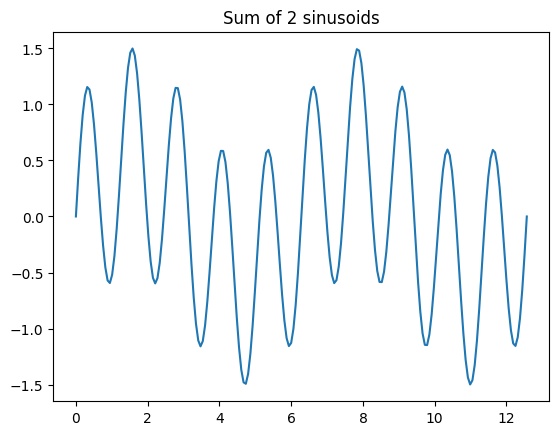

In [ ]:
x = np.linspace(0, 4*np.pi, 200)
sin1 = 0.5 * np.sin(x)
sin2 = np.sin(5*x)
sin3 = sin1 + sin2
plt.plot(x, sin3)
plt.title('Sum of 2 sinusoids')
plt.show()

In one period the value inside the sin function must change by $2\pi$, so the value before the x must be equal to $2\pi/T$ where $T$ is the period of the function. The frequency itself is actually $1/T$, so its value is $2\pi$ times lower than the numbers we inserted into our sinusoids, or, more preccisely, $0.796$ for sin2 and $0.159$ for sin1 in absolute.

Apply FFT to sin3 series to obtain frequency decomposition and plot the results.

In [ ]:
def fft_plot(x_values, sample_rate, max_freq=5, ylimit=2000):
  yf = fft(x_values)
  yf = np.sqrt(yf * np.conj(yf))
  xf = fftfreq(len(x_values), 1 / sample_rate)
  plt.plot(xf[(xf >= 0) & (xf <= max_freq)], 2*yf[(xf >= 0) & (xf <= max_freq)]/len(x_values))
  plt.grid()
  plt.ylim(0,ylimit)
  plt.show()

The adjustment of y terms in above function is due to the fact that we ignore the negative symmetric frequency (thus multiply the positive by 2), and we have to divide the amplitude by the number of sample points made (from scipy fft documentation).

/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


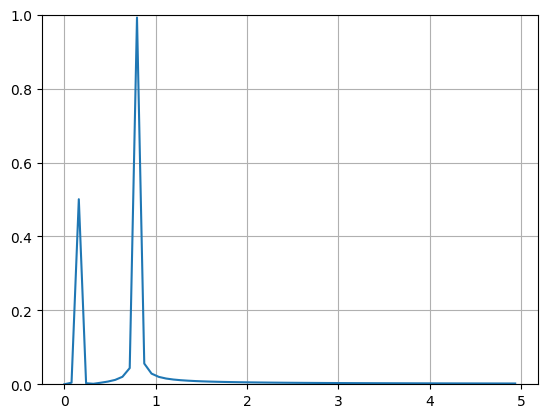

In [ ]:
# Plot Frequency-domain plot here
fft_plot(sin3, 200/(4*np.pi), ylimit=1) # 200 / (4 * np.pi) because it is number of samples per 1 unit

Make sure that you got 2 spikes corresponding to the frequencies that we assigned to the sinusoids earlier. Explain how the transformation is conducted and why we can obtain two perfectly separated frequencies from a mixed signal. 



Last year on the other course we about talked the Fourier series that are used to represent a function as an infinite sum of periodic sine and cosine functions. It gives us the idea that a very complicated signal may be represented as a sum of multiple sine and cosine functions, and already existing Fourier transform (which is a non-discrete version of DFT which is actually performed by FFT algorithms) allows us, using the function that depends on time (for example), to get the function that will describe frequencies, present in the original one.

## Working with example audio

Now, let's work with a more complex wave&mdash;sound. Any sound (audio signal) can be characterized by the following three quantities: Pitch, Quality, and Loudness.

Loudness is a physiological sensation that depends mainly on the sound wave pressure (amplitude). 

The lowest note in a chord is called fundamental. It is heard predominantly due to larger intensity. Quality is determined by overtones or harmonics that add to the sound of a fundamental note.

Pitch is the frequency of a sound as perceived by human ear. A high frequency gives rise to a high pitch note and a low frequency produces a low pitch note. A pure tone is the sound of only one frequency, such as that given by a tuning fork or electronic signal generator. Naturally, music does not consist of pure tones. Depending on an instrument, technique and many other factors, sound will decay at different rates and one tone will mix with the other ones.

Thus, transcribing audio files into standard music notation (i.e., the notes) is a non-trivial task. We will focus on recognizing pitches and matching them to notes. 

### Load and explore

In [ ]:
# Load first sound from library examples
# Monophonic trumpet recording
trumpet_path = librosa.example('trumpet')
Audio(trumpet_path)

In [ ]:
trumpet_sample, trumpet_sampling_rate = librosa.load(trumpet_path)

What is a sampling rate? What does sampling rate imply about the audio? Is it sufficient for our task (according to https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem)?


Sampling rate refers to the number of samples of an analog audio signal that are taken per second to convert it into a digital format. The unit of measurement for sampling rate is Hertz (Hz), which represents the number of samples per second.

The sampling rate of an audio recording implies several things about the quality and fidelity of the digital audio signal. Generally speaking, a higher sampling rate results in better audio quality and a more accurate representation of the original analog sound wave. This is because a higher sampling rate allows for more samples to be taken per second, which means that more detail can be captured in the digital signal.

In our task we have to deal with not very high frequencies which we would see on the further FFT representations, which means, that sampling rate of 21050 Hz is sufficient for us, as it is more than twice higher, than the highest frequency of our signal.

In [ ]:
def time_domain(x_values, sample_rate):
  time = np.array(range(x_values.shape[0])) / sample_rate
  plt.plot(time, x_values)
  plt.title('Time-domain representation')
  plt.xlabel('time, seconds')
  plt.show()

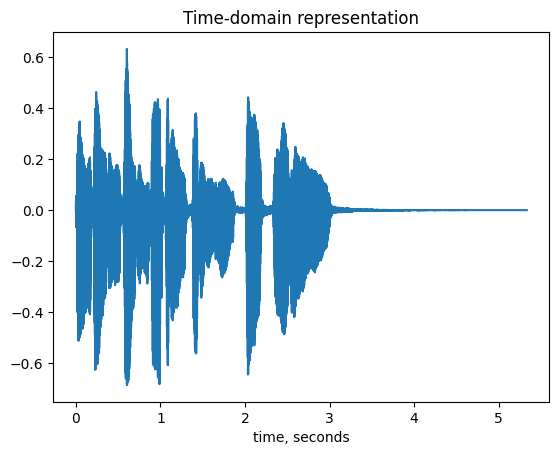

In [ ]:
# Initial visualization
time_domain(trumpet_sample, trumpet_sampling_rate)

This visualization is called the time-domain representation of a given signal. This shows us the loudness (amplitude) of sound wave changing with time. Here amplitude = 0 represents silence. These amplitudes are not very informative as they only represent the loudness of audio recording. To better understand the audio signal, it is necessary to transform it into the frequency domain. The frequency-domain representation of a signal tells us which frequencies are present in the signal.

Decompose the trumpet samples using fft and plot the results. Observe that the frequency pattern corresponds to the pitch changes.

/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


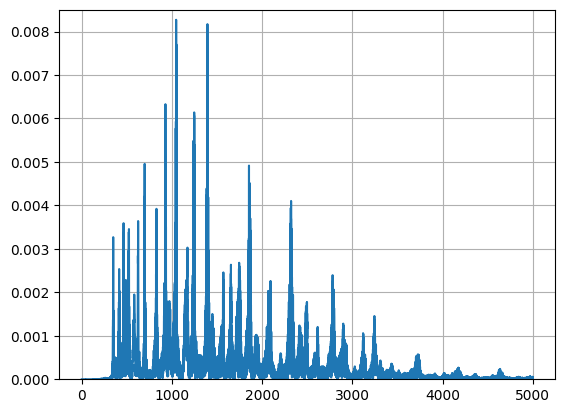

In [ ]:
# FFT for trumpet
fft_plot(trumpet_sample, trumpet_sampling_rate, max_freq = 5000, ylimit = 1000/len(trumpet_sample))

## Analyzing a song

In the next task, you need to use the recording of a famous Ukrainian song attached on cms. Your creativity is not limited here so any better ways to filter noise, compelling visuals, more advanced algorithms on top of FFT or spectrogram, and explanations will be rewarded.     


1.   Load the recording, replay it, and plot in the time domain. To get a better view of how the notes change throughout a shorter time, choose a sample of the audio up to 5 seconds and plot it in the time domain. From here on out you will be working with this smaller 5-second sample.


In [ ]:
# Loading sound
path = '/content/piano_melody.mp3'
samples, sampling_rate = librosa.load(path)
Audio(path)

In [ ]:
# Creating a 5-second sample of the audio
START = 1.6
samples = samples[int(START * sampling_rate):(int(START * sampling_rate) + 5 * sampling_rate)]
print(len(samples))

110250


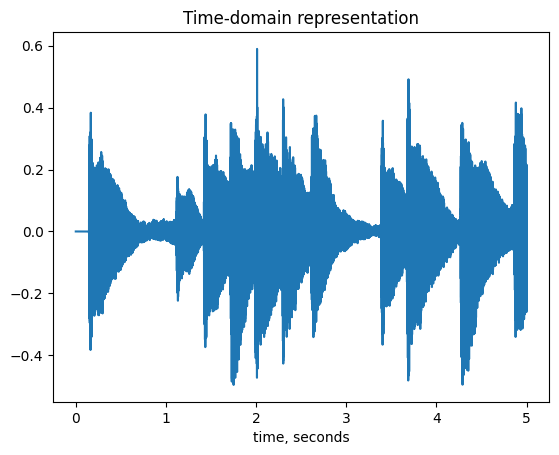

In [ ]:
time_domain(samples, sampling_rate)

2.   Build a spectrogram of the sample. Explain what domain the spectrogram represents us and how can it be useful.


In [ ]:
def spectogram(sample, sampling_rate):
  # Generate spectrogram
  spectrogram = librosa.feature.melspectrogram(y=sample, sr=sampling_rate)

  # Convert to dB
  spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

  # Set the reference power to 0 dB
  spectrogram_db -= np.max(spectrogram_db)

  # Plot spectrogram
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(spectrogram_db, y_axis='mel', x_axis='time')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel Spectrogram')
  plt.tight_layout()
  plt.show()

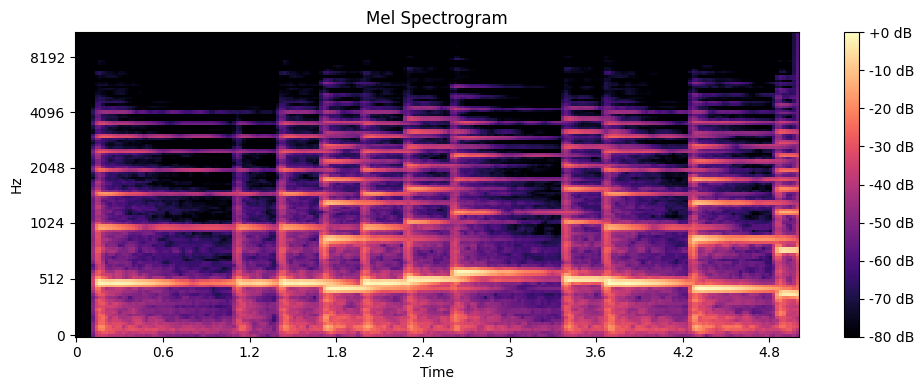

In [ ]:
spectogram(samples, sampling_rate)

A spectrogram is a visual representation of the frequency content of a sound signal over time. In fact, it is frequency domain for each distinct moment.

As we can see, x-axis representing the time and y-axis representing frequencies. The color or shading of each point in the spectrogram indicates the magnitude of the frequency component at that particular time and frequency.

Spectogram is very useful to observe frequencies in each moment over time. In our case, it is very obvious when each note is pressed and how the main frequency shading is changing. With such spectogram it is possible to create music papers for the song.

3.   Transform signal to the frequency domain with FFT and study the distribution of pitches (frequencies).
Observe that the melody contains only a couple of distinct sounds, but there are a lot more spikes in the frequency domain.

/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


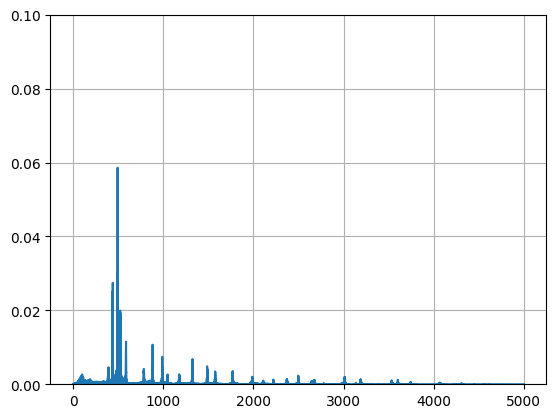

In [ ]:
# Your code here
fft_plot(samples, sampling_rate, 5000, 0.1)

We can see, that number of spikes is indeed higher than 4 or 5. It is because of harmonics, that are playing with each note. Each note 'duplicates' itself on frequency, which is an integral (whole number) multiple of the frequency of the same reference signal. Because of that we have not only main notes with frequencies around 450 to 700 Hz, but also its harmonics on the whole x-axis.

4.    Find typical piano notes frequencies table and suggest a way of filtering noise. (Hint: minimum pitch for a piano is 27.5 Herz)  

In [ ]:
# Your code here
piano_frequencies = [16.35, 17.32, 18.35, 19.45, 20.60, 21.83, 23.12, 24.50, 25.96, 27.50, 29.14, 30.87, 32.70, 34.65, 36.71, 38.89, 41.20, 43.65, 46.25, 49.00, 51.91, 55.00, 58.27, 61.74, 65.41, 69.30, 73.42, 77.78, 82.41, 87.31, 92.50, 98.00, 103.83, 110.00, 116.54, 123.47, 130.81, 138.59, 146.83, 155.56, 164.81, 174.61, 185.00, 196.00, 207.65, 220.00, 233.08, 246.94, 261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 392.00, 415.30, 440.00, 466.16, 493.88, 523.25, 554.37, 587.33, 622.25, 659.25, 698.46, 739.99, 783.99, 830.61, 880.00, 932.33, 987.77, 1046.50, 1108.73, 1174.66, 1244.51, 1318.51, 1396.91, 1479.98, 1567.98, 1661.22, 1760.00, 1864.66, 1975.53, 2093.00, 2217.46, 2349.32, 2489.02, 2637.02, 2793.83, 2959.96, 3135.96, 3322.44, 3520.00, 3729.31, 3951.07, 4186.01]

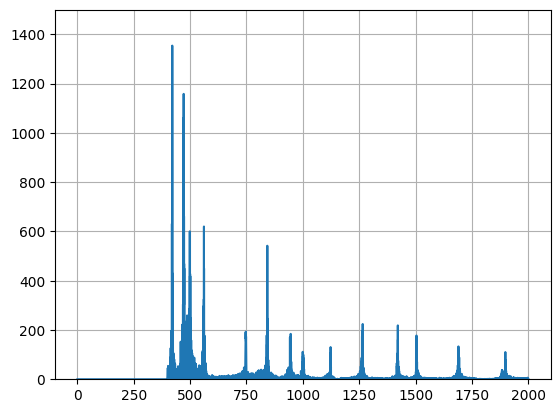

In [ ]:
denoised = samples.copy()
yf = fft(denoised)
xf = fftfreq(len(denoised), 1 / 21050)
zero_mask = (xf < 400)
yf[zero_mask] = 0
plt.plot(xf[(xf >= 0) & (xf <= 2000)], (yf[(xf >= 0) & (xf <= 2000)]))
plt.grid()
plt.ylim(0,1500)
plt.show()

In [ ]:
result = ifft(yf)

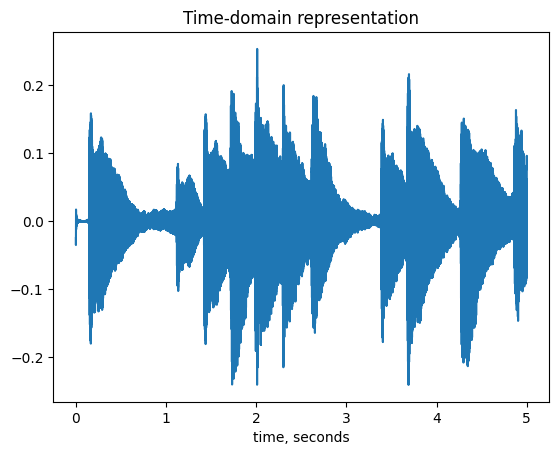

In [ ]:
time_domain(result, sampling_rate)

In [ ]:
def play_audio(sample, sr):
  new_sig = sample
  norm_new_sig = np.int16(new_sig * (32767 / new_sig.max()))
  write("clean.wav", sr, norm_new_sig)
  return Audio("clean.wav")

In [ ]:
play_audio(result, sampling_rate)

<ipython-input-22-5e77e53bef13>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  norm_new_sig = np.int16(new_sig * (32767 / new_sig.max()))


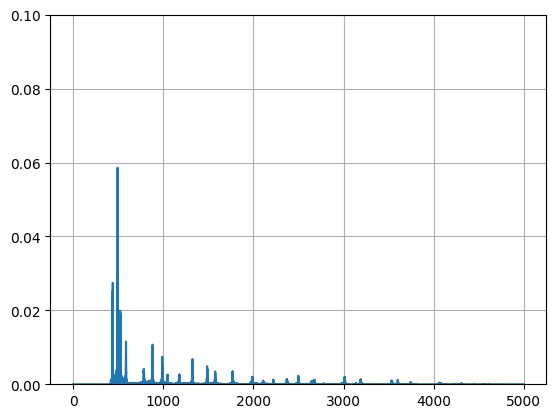

In [ ]:
fft_plot(result, sampling_rate, 5000, 0.1)

In this task we tried two ways of filtering and ended up with simple crop of the left side spectrum (results in a pretty pure clean sound). We checked Hymn notes and observed that the lowest frequency present is 400 hz, so we equaled to zero everything lower than this frequency. 

We first tried to only include piano notes in the resulting frequency-domain representation, but the transitions between the notes were drastic and hard to comprehend. Some offset choices also included a few noise frequencies and sound artifacts appeared. 

We also tried to set some y-line for zerowing-out everything smaller than this value, but the result was similar to the one from previous approach.


5. Apply averaging to the initial signal. Averaging is a procedure that reduces number of samples by taking mean of each n of our samples. Experiment with n and determine whichever will work best to both reduce the noise and not loose any information. You can propose other ways to efficiently denoise the signal.

In [ ]:
# Your code here
def averaging(sample, sr, n = 1):
  new_sample = [np.mean(sample[n*i:n*(i+1)]) for i in range(len(sample)//n)]
  new_sr = int(len(new_sample)/len(sample)*sr)  # time of audio must remain the same => len(sample)/sr = len(new_sample)/new_sr
  return (np.array(new_sample), new_sr)

In [ ]:
new_sample, new_sr = averaging(samples, sampling_rate, n = 5)
play_audio(new_sample, new_sr)

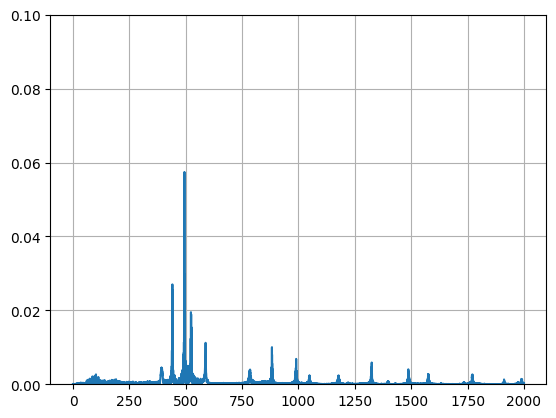

In [ ]:
fft_plot(new_sample, new_sr, 2000, 0.1)

We performed averagening on our sample and realized that for our case it is not that effective. Generally, the idea behind the procedure is next: we assume that the error (noise) have some distribution with 0 expected value, so we can denoise the signal by taking average from some interval. The signal itself also should not suffer in case of high sampling rate. However, as our audio was initially pretty clear, there is a problem as even if some intervals denoised, the original signal became much quiter (can be seen at frequency-domain graph). So, we settled for low n values (2-4) which although don`t make such a big of difference.

6. Match fundamental pitches you discovered to the standard note frequencies and display them in a table like the one outlined below.

|Detected frequency(Hz) | Assigned frequency(Hz) | Output note|   
|:---------------------:|:----------------------:|:----------:|
|393.2 |391.9| G4  

In [ ]:
def fft_freques(sample, sr):
  average = sample.copy()
  yf = fft(average)
  xf = fftfreq(len(average), 1 / sr)
  OFFSET = 10
  ERROR = 3
  MIN_VALUE = 550
  detected = np.array([])
  assigned = np.array([])
  for piano_freq in piano_frequencies:
    if (yf[(xf < piano_freq + OFFSET + ERROR) & (xf > piano_freq - OFFSET + ERROR)] > MIN_VALUE).any():
      detected_mask = ((xf < piano_freq + OFFSET + ERROR) & (xf > piano_freq - OFFSET + ERROR))
      detected = np.append(detected, np.median(xf[detected_mask]))
      assigned = np.append(assigned, piano_freq)
  detected = np.unique(detected)
  return (detected, assigned)

In [ ]:
# Your code here
freqs_detected, freqs_assigned = fft_freques(samples, sampling_rate)
notes = librosa.hz_to_note(freqs_assigned)
notes_data = {'Detected frequency(Hz)': freqs_detected, 'Assigned frequency(Hz)': freqs_assigned, 'Output note': notes}
notes_df = pd.DataFrame(data = notes_data)
display(notes_df)

,Detected frequency(Hz),Assigned frequency(Hz),Output note
0,443.0,440.00,A4
1,496.9,493.88,B4
2,526.3,523.25,C5
3,590.3,587.33,D5


To find fundamental notes we made script, that checked for notes frequencies and certain level of values of FFT in some offset from piano note frequencies. For example, if we want to know, if there is note B4 with frequency 493.88 Hz, then we check for FFT values with value over 550 in range of 483.88 Hz and 503.88 Hz. If there is such value, than we assign it, if no, then we skip it.

With use of such method we manage to get all 4 notes, that are in fact played in first 5 seconds of Ukrainian anthem.

## Summary

1. What is Fourier transform? How can it be used in signal processing?


Fourier transform is a linear mapping that converts a given function from its original domain to a frequency domain, showing what frequencies are present in the original function. It, or to be more precise, its discrete form has a huge practical field of usage. All the observed quantites that are gathered and that can be interpreted as signals (from sound to temperature waves) are analysed using this method to better understand the origins of the signal and filter it for further usage.

2. What are time and frequency domains and how can they be useful?

Time and frequency domains are different types of representation of our sound signal, though both of them are very useful to analyse its nature.
Time domain is a representation of amplitude of our sound over length of our signal as a function of time. For songs in our lab, the length is its duration in seconds. The height of corresponding columns is an amplitude of sound in that exact moment.

Frequency domain refers to the analysis of signals in terms of their frequency components. In the frequency domain, a signal is represented as a combination of sinusoidal components, each with a specific frequency, amplitude, and phase.

The choice between time and frequency domain analysis depends on the application and the type of signal being analyzed. In some cases, time domain analysis is more appropriate, while in others, frequency domain analysis may be more useful. However, in most cases, a combination of both time and frequency domain analysis is necessary to fully understand a signal.

3. What is averaging and what is its purpose?

Averaging is a signal denoising technique applied to time-domain representation of the signal. The idea is to take average of some sample interval. The reason it is supposed to work is the assumption that error has a zero mean. So, one of the requirements for the input is high sampling rate, as we need error sample mean to converge to its true value of 0. Having bigger interval sizes also should help, yet it may negatively effect the original signal, so here the need to compromise erises. 

In this lab we used averaging for denoising, so the purpose of it was achieving clearer sound. Analogically, the approach can be applied to any contineous signal with corresponding error distribution. Another possible application of the technique is compressing of data, as output size decreases n times, but it  causes losses, so the quality of data also drops.